In [1]:
from scipy.signal import decimate, detrend
import numpy as np
import matplotlib.pyplot as plt
from Rfuns import bw_nrd0_R, smooth_spline_R
import torch
from gTVDNutils import *
from easydict import EasyDict as edict
from tqdm.autonotebook import tqdm
import seaborn as sns
import time
from scipy.io import loadmat
from pathlib import Path

%matplotlib inline

In [2]:
resDir = Path("../results")
dataDir = Path("../data")

In [34]:
# optimization class
class OneStepOpt():
    """
        I concatenate the real and image part into one vector.
    """
    def __init__(self, X, Y, iTheta=None, iRho=None, penalty="SCAD", is_ConGrad=False, **paras):
        """
         Input: 
             Y: A matrix with shape, R x n, Complex
             X: A matrix with shape, R x n, 
             iTheta: The initial parameters for theta, vector of 2R(n-1), real data
             iRho: initial value, a vector of length (D-1)2R, real data
             penalty: The penalty type, "SCAD" or "GroupLasso"
             is_ConGrad: Whether to use conjugate gradient method to update gamma or not. 
                        When data are large, it is recommended to use it
             paras:
                 beta: tuning parameter for iteration
                 alp: tuning parameter for iteration
                 lam: the parameter for SCAD/Group lasso
                 a: the parameter for SCAD, > 1+1/beta
                 iterNum:  integer, number of iterations
                           if iterNum < 0, optimization without penalty.
                 iterC: decimal, stopping rule
                 eps: decimal, stopping rule for conjugate gradient method
                 b: radius of the L1-ball projection
        """
        
        parasDefVs = {"a": 2.7,  "beta": 1, "alp": 0.9,  "lam": 1e2, 
                      "iterNum": 100, "iterC": 1e-4, "eps": 1e-6, "b": 100}
        
        self.paras = edict(parasDefVs)
        for key in paras.keys():
            self.paras[key] = paras[key]
        
            
            
        self.R, self.n = X.shape
        self.R2 = 2*self.R
        self.X = X
        self.Y = Y
        
        self.rho = iRho
        if self.rho is None:
            self.rho = torch.ones(self.R2*(self.n-1))
            
        self.vecTheta= iTheta
        if self.vecTheta is None:
            self.vecTheta = torch.randn(self.R2*(self.n-1))
            
        
        self.newVecGam = None
        self.halfRho = None
        self.penalty = penalty.lower()
        self.is_ConGrad = is_ConGrad
            
        self.leftMat = None
        self.leftMatVec = None
        self.NewXYR2 = None
        
        self.NewXr = X.real
        self.NewYr = Y.real
        self.NewXi = X.imag
        self.NewYi = Y.imag
        
        self.GamMat = None
        self.ThetaMat = None
        self.numEs = 1
        
        self.chDiff = torch.tensor(1e10)
        self.lastVecGam = None
        self.lastRho = None
        self.lastVecTheta = None
        
        self.errs = []
        
    def _LeftMatOpt(self, vec):
        rVec1 = self.leftMatVecP1 * vec
        rVec2 = self.paras.beta * DiffMatTOpt(DiffMatOpt(vec, self.R2), self.R2)
        return rVec1 + rVec2
    
    def _ConjuGrad(self, vec, maxIter=1000):
        """ 
        Ax = vec
        """
        eps = self.paras.eps
        
        xk = torch.zeros_like(vec)
        rk = vec - self._LeftMatOpt(xk)
        pk = rk
        if torch.norm(rk) <= eps:
            return xk
        
        for k in range(maxIter):
            alpk = torch.sum(rk**2) / torch.sum(pk * self._LeftMatOpt(pk))
            xk = xk + alpk * pk 
            
            rk_1 = rk
            rk = rk - alpk * self._LeftMatOpt(pk)
            
            if torch.norm(rk) <= eps:
                break 
                
            betk = torch.sum(rk**2)/torch.sum(rk_1**2)
            pk = rk + betk * pk
            
        return xk
        
    
    def updateVecGam(self):
        """
            I use conjugate gradient to solve it. 
            Update the Gamma matrix, first step 
        """
        self.DiffMatSq = genDiffMatSqfn(self.R2, self.n) # R2n x R2n
        
        
        if self.leftMat is None:
            NewXSq = self.NewXr**2 + self.NewXi**2 # R x n
            NewXSqR2 = torch.cat((NewXSq, NewXSq), dim=0) # 2R x n
            self.leftMat = torch.diag(NewXSqR2.T.flatten()/self.numEs).to_sparse() +  \
                    self.paras.beta * self.DiffMatSq
        
        if self.NewXYR2 is None:
            NewXY1 = self.NewXr * self.NewYr + self.NewXi * self.NewYi # R x n
            NewXY2 = - self.NewXi * self.NewYr + self.NewXr * self.NewYi # R x n
            self.NewXYR2 = torch.cat((NewXY1, NewXY2), dim=0) # 2R x n
        rightVec = self.NewXYR2.T.flatten()/self.numEs + \
                    DiffMatTOpt(self.rho + self.paras.beta * self.vecTheta, self.R2)
        
        self.newVecGam, _  = torch.solve(rightVec.reshape(-1, 1), self.leftMat.to_dense()) 
        self.newVecGam = self.newVecGam.reshape(-1)
        
    def updateVecGamConGra(self):
        """
            Update the Gamma matrix, first step, wth Conjugate Gradient Method
        """
        
        if self.leftMat is None:
            NewXSq = self.NewXr**2 + self.NewXi**2
            NewXSqR2 = torch.cat((NewXSq, NewXSq), dim=0) # 2R x n
            self.leftMatVecP1 = NewXSqR2.T.flatten()/self.numEs
        
        if self.NewXYR2 is None:
            NewXY1 = self.NewXr * self.NewYr + self.NewXi * self.NewYi
            NewXY2 = - self.NewXi * self.NewYr + self.NewXr * self.NewYi
            self.NewXYR2 = torch.cat((NewXY1, NewXY2), dim=0) # 2R x n
        rightVec = self.NewXYR2.T.flatten()/self.numEs + \
                    DiffMatTOpt(self.rho + self.paras.beta * self.vecTheta, self.R2)
        
        self.newVecGam = self._ConjuGrad(rightVec)
    
    def projVecGam(self):
        """
        project Vec(Gam) in L1-ball with radius b based on mode as complex numbers
        """
        GamMat = colStackFn(self.newVecGam, self.R2)
        GamMatCplx = torch.complex(GamMat[:self.R, :], GamMat[self.R:, :])
        newVecGamMode = GamMatCplx.abs().T.flatten()
        projVecGamMode = euclidean_proj_l1ballTorch(newVecGamMode, self.paras.b)
        projGamMode = colStackFn(projVecGamMode, self.R)
        projGamMatCplx = GamMatCplx * projGamMode/GamMatCplx.abs()
        GamMat = torch.cat([projGamMatCplx.real, projGamMatCplx.imag])
        self.newVecGam = GamMat.T.flatten()
        
    def updateHRho(self):
        """
            Update the vector rho at 1/2 step, second step
        """
        halfRho = self.rho - self.paras.alp * self.paras.beta * (DiffMatOpt(self.newVecGam, self.R2) - self.vecTheta)
        self.halfRho = halfRho
       
    
    def updateTheta(self):
        """
            Update the vector Theta, third step
        """
        halfTheta = DiffMatOpt(self.newVecGam, self.R2) - self.halfRho/self.paras.beta
        tranHTheta = halfTheta.reshape(-1, self.R2) # n-1 x 2R
        hThetaL2Norm = tranHTheta.abs().square().sum(axis=1).sqrt() # n - 1
        normCs = torch.zeros_like(hThetaL2Norm) - 1
        
        normC1 = hThetaL2Norm - self.paras.lam/self.paras.beta
        normC1[normC1<0] = 0
        
        normC2 = (self.paras.beta * (self.paras.a - 1) * hThetaL2Norm - self.paras.a * self.paras.lam)/(self.paras.beta * self.paras.a - self.paras.beta -1)
        
        c1 = (1+1/self.paras.beta)* self.paras.lam
        c2 = self.paras.a * self.paras.lam
        
        normCs[hThetaL2Norm<=c1] = normC1[hThetaL2Norm<=c1]
        normCs[hThetaL2Norm>c2] = hThetaL2Norm[hThetaL2Norm>c2]
        normCs[normCs==-1] = normC2[normCs==-1]
        
        normCs[normCs!=0] = normCs[normCs!=0]/hThetaL2Norm[normCs!=0]
        
        self.vecTheta = (tranHTheta*normCs.reshape(-1, 1)).flatten()
        
    def updateThetaGL(self):
        """
            Update the vector Theta, third step with group lasso penalty
        """
        halfTheta = DiffMatOpt(self.newVecGam, self.R2) - self.halfRho/self.paras.beta
        tranHTheta = halfTheta.reshape(-1, self.R2) # n-1 x 2R
        hThetaL2Norm = tranHTheta.abs().square().sum(axis=1).sqrt() # n-1
        
        normC1 = hThetaL2Norm - self.paras.lam
        normC1[normC1<0] = 0
        
        normCs = normC1
        
        normCs[normC1!=0] = normC1[normC1!=0]/hThetaL2Norm[normC1!=0]
        self.vecTheta = (tranHTheta*normCs.reshape(-1, 1)).flatten()
        
    
    def updateRho(self):
        """
            Update the vector rho, fourth step
        """
        newRho = self.halfRho - self.paras.alp * self.paras.beta * (DiffMatOpt(self.newVecGam, self.R2) - self.vecTheta)
        self.rho = newRho
        
        
    def OneLoop(self):
        """
        Run one loop for the opt
        """
        
        ts = []
        ts.append(time.time())
        if self.is_ConGrad:
            self.updateVecGamConGra()
        else:
            self.updateVecGam()
            
        ts.append(time.time())
            
        self.projVecGam()
        
        ts.append(time.time())
        
        self.updateHRho()
        ts.append(time.time())
        
        if self.penalty.startswith("scad"):
            self.updateTheta()
        elif self.penalty.startswith("group"):
            self.updateThetaGL()
        ts.append(time.time())
        
        self.updateRho()
        ts.append(time.time())
        #print(np.diff(ts))
       
    def DiffVal(self):
        """
        Calculate the stopping criterion
        """
        v1 = torch.norm(self.vecTheta-self.lastVecTheta)*self.paras.beta
        v2 = torch.norm(self.rho-self.lastRho)/self.paras.beta
        npara = len(self.rho)
        self.chDiff = torch.max(v1, v2)/np.sqrt(npara)
        self.errs.append([self.chDiff, v1/np.sqrt(npara), v2/np.sqrt(npara)])
        
    
    def __call__(self, is_showProg=False, leave=False, **paras):
        for key in paras.keys():
            self.paras[key] = paras[key]
        if self.paras.iterC is None:
            self.paras.iterC = 0
        
        self.OneLoop()
        
        if is_showProg:
            with tqdm(total=self.paras.iterNum, leave=leave) as pbar:
                for i in range(self.paras.iterNum):
                    pbar.set_description(f"Inner Loop: The chdiff is {self.chDiff.item():.3e}.")
                    pbar.update(1)
                    
                    self.lastVecGam = self.newVecGam
                    self.lastRho = self.rho
                    self.lastVecTheta = self.vecTheta
                    
                    self.OneLoop()
                    self.DiffVal()
                    
                    
                    if self.chDiff < self.paras.iterC:
                        pbar.update(self.paras.iterNum)
                        break
        else:
            for i in range(self.paras.iterNum):
                
                self.lastVecGam = self.newVecGam
                self.lastRho = self.rho
                self.lastVecTheta = self.vecTheta
                
                self.OneLoop()
                self.DiffVal()
                
                if self.chDiff < self.paras.iterC:
                    break
        
        self._post()
            
    def _post(self):
        self.GamMat = colStackFn(self.newVecGam, self.R2) # 2R x n
        self.ThetaMat = colStackFn(self.vecTheta, self.R2) # 2R x (n-1)

In [3]:
filAD = "87ADs_before_filter1000.mat"
filCtrl = "70Ctrls_before_filter1000.mat"
filADadd = "DK_timecourse.mat"

In [4]:
ADdatasets = loadmat(dataDir/filAD)["dk10"]
Ctrldatasets = loadmat(dataDir/filCtrl)["dk10"]

### Test

In [5]:
N, d, nF = ADdatasets.shape

In [26]:
paras = edict()
paras.nR = 12
paras.decimateRate = 50
paras.is_detrend = True
paras.T = 2
paras.lamb = 1e-4
paras.downrate = 10
paras.fct = 1

### Obtain the A mat

In [27]:
def GetNewEst(dXmats, Xmats, Amat, r, is_full=False, showProg=False):
    """
    Input: 
        dXmat, Estimated first derivative of X(t), N x d x n
        Xmat, Estimated of X(t), N x d x n
        Amat: The A matrix to to eigendecomposition, d x d
        r: The number of eigen values to keep
        is_full: Where return full outputs or not
    Return: 
        nXmat, ndXmat, rAct x n 
    """
    N = len(dXmats)
    eigVals, eigVecs = np.linalg.eig(Amat)
    eigValsfull = np.concatenate([[np.Inf], eigVals])
    kpidxs = np.where(np.diff(np.abs(eigValsfull))[:r] != 0)[0]
    eigVecsInv = np.linalg.inv(eigVecs)
    nXmats, ndXmats = [], []
    if showProg:
        progBar = tqdm(range(N))
    else:
        progBar = range(N)
    for i in progBar:
        dXmat, Xmat = dXmats[i], Xmats[i]
        nXmat = eigVecsInv[kpidxs, :].dot(Xmat)
        ndXmat = eigVecsInv[kpidxs, :].dot(dXmat)
        nXmats.append(nXmat)
        ndXmats.append(ndXmat)
    if is_full:
        return edict({"ndXmats":ndXmats, "nXmats":nXmats, "kpidxs":kpidxs, "eigVecs":eigVecs, "eigVals":eigVals, "r": r})
    else:
        return ndXmats, nXmats

In [28]:
N = 10
Amat = 0
dXmats, Xmats = [], []
for i in tqdm(range(N)):
    Ymat = ADdatasets[i, :, :]
    nYmat = PreProcess(Ymat, paras.decimateRate, paras.is_detrend) 
    d, n = nYmat.shape
    times = np.linspace(0, paras.T, n)
    dXmat, Xmat = GetBsplineEst(nYmat, times, lamb=paras.lamb)
    dXmats.append(dXmat)
    Xmats.append(Xmat)
    Amat = GetAmat(dXmat, Xmat, times, downrate=paras.downrate, fct=paras.fct) + Amat

In [29]:
midRes = GetNewEst(dXmats, Xmats, Amat, r=paras.nR, is_full=True, showProg=False)
ndXmats, nXmats = midRes["ndXmats"], midRes["nXmats"]

In [30]:
ndXmat, nXmat = ndXmats[0], nXmats[0]
R, n = nXmat.shape
Y = torch.tensor(ndXmat)
X = torch.tensor(nXmat)

In [79]:
opt = OneStepOpt(X=X, Y=Y, is_ConGrad=True, penalty="Grouplasso", lam=5e4, b=6e5, iterC=1e-4, iterNum=10000, beta=10, alp=0.9)
opt(True, True)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



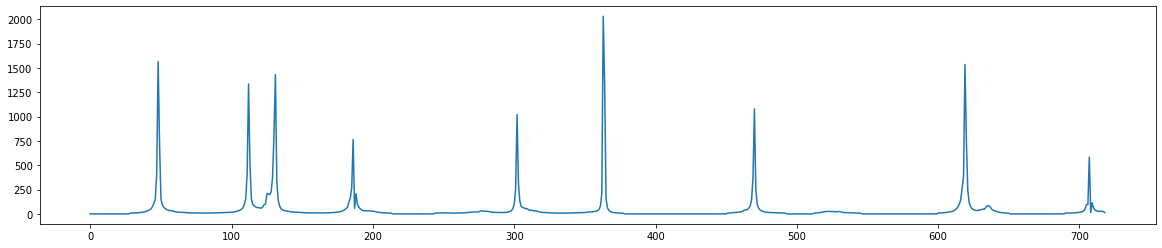

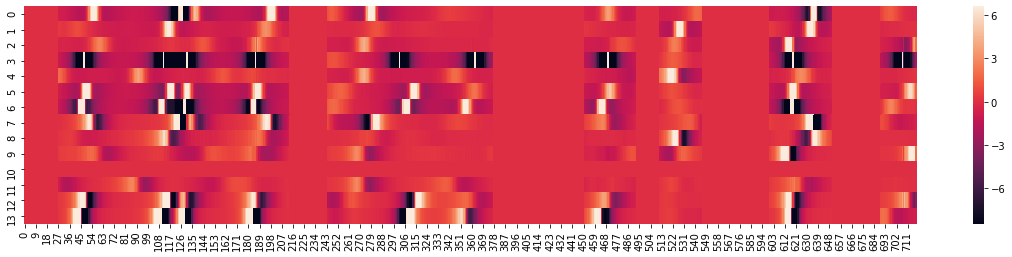

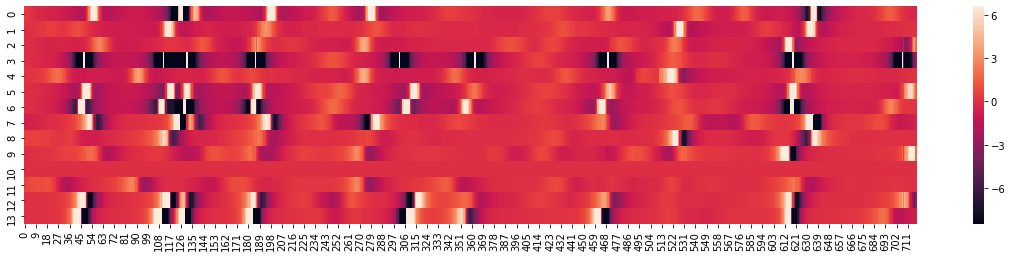

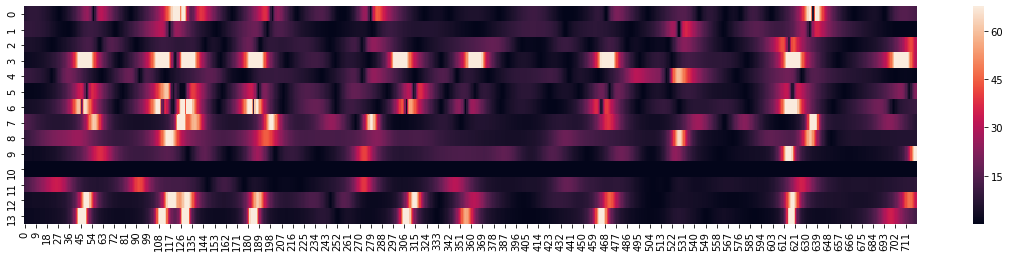

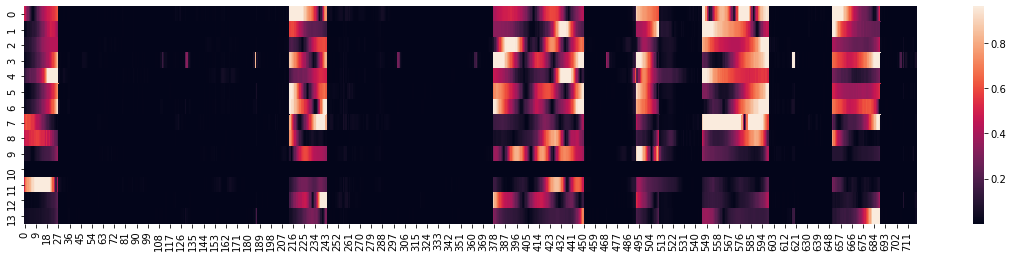

In [80]:
plt.figure(figsize=[20, 4])
plt.plot(opt.ThetaMat.abs().sum(dim=0))
plt.figure(figsize=[20, 4])
sns.heatmap(opt.ThetaMat.cpu(), robust=True)
plt.figure(figsize=[20, 4])
sns.heatmap(torch.diff(opt.GamMat.cpu(), dim=-1), robust=True)
plt.figure(figsize=[20, 4])
sns.heatmap((opt.GamMat.cpu().abs()), robust=True)
plt.figure(figsize=[20, 4])
sns.heatmap((torch.diff(opt.GamMat.cpu(), dim=-1)-opt.ThetaMat.cpu()).abs(), robust=True)

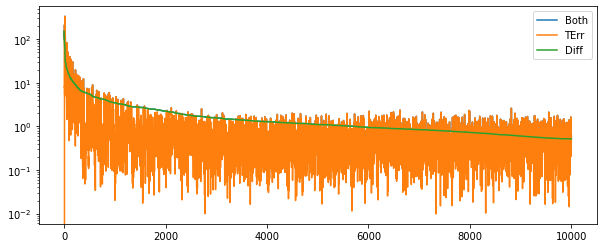

In [81]:
Errs = np.array(opt.errs)
plt.figure(figsize=[10, 4])
plt.plot(Errs[:, 0], label="Both")
plt.plot(Errs[:, 1], label="TErr")
plt.plot(Errs[:, 2], label="Diff")
plt.yscale("log")
plt.legend()